# Sentiment Analysis Notebook

This notebook walks through loading text data, cleaning it, performing basic sentiment scoring with TextBlob, and training multiple models to classify sentiment.

## 1. Install and Import Required Libraries

In [8]:
# If needed, uncomment to install dependencies.
# %pip install pandas numpy nltk textblob scikit-learn matplotlib seaborn wordcloud

import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

from wordcloud import WordCloud

warnings.filterwarnings("ignore")

# Download NLTK resources if not already present.
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 2. Load and Explore the Dataset

We will try to load one of the CSV files in the workspace. The Sentiment140 format uses columns:
`target, ids, date, flag, user, text`.

In [9]:
workspace_path = Path("d:/Customer Sentiment Analyzer")

candidates = [
    workspace_path / "train.csv",
    workspace_path / "test.csv",
    workspace_path / "testdata.manual.2009.06.14.csv",
    workspace_path / "training.1600000.processed.noemoticon.csv",
]

existing_files = [p for p in candidates if p.exists()]
existing_files

[WindowsPath('d:/Customer Sentiment Analyzer/train.csv'),
 WindowsPath('d:/Customer Sentiment Analyzer/test.csv'),
 WindowsPath('d:/Customer Sentiment Analyzer/testdata.manual.2009.06.14.csv'),
 WindowsPath('d:/Customer Sentiment Analyzer/training.1600000.processed.noemoticon.csv')]

In [10]:
# Load the default dataset (train) if available
if not existing_files:
    raise FileNotFoundError("No CSV files found in the workspace path.")

default_csv = "testdata.manual.2009.06.14.csv"
csv_path = next((p for p in existing_files if p.name == default_csv), None)
if csv_path is None:
    csv_path = existing_files[0]

# Sentiment140 files are often latin-1 encoded
try:
    df = pd.read_csv(csv_path, header=None, encoding="latin-1")
except UnicodeDecodeError:
    df = pd.read_csv(csv_path, header=None, encoding="utf-8")

# Try to infer columns
if df.shape[1] >= 6:
    df = df.iloc[:, :6]
    df.columns = ["target", "ids", "date", "flag", "user", "text"]
else:
    df.columns = [f"col_{i}" for i in range(df.shape[1])]

print(f"Loaded: {csv_path.name}")
df.head()

Loaded: testdata.manual.2009.06.14.csv


,target,ids,date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [11]:
# Basic exploration
print(df.info())
print(df["target"].value_counts() if "target" in df.columns else "No target column detected")

<class 'pandas.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  516 non-null    int64
 1   ids     516 non-null    int64
 2   date    516 non-null    str  
 3   flag    516 non-null    str  
 4   user    516 non-null    str  
 5   text    516 non-null    str  
dtypes: int64(2), str(4)
memory usage: 87.7 KB
None
target
4    198
0    178
2    140
Name: count, dtype: int64


## 3. Preprocess Text Data

We clean the text by lowercasing, removing special characters, removing stopwords, and lemmatizing.

In [12]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [
        lemmatizer.lemmatize(word)
        for word in text.split()
        if word not in stop_words and len(word) > 1
    ]
    return " ".join(tokens)

# Sample subset for quick iteration on large datasets
sample_df = df.copy()
if len(sample_df) > 200000:
    sample_df = sample_df.sample(200000, random_state=42)

sample_df["clean_text"] = sample_df["text"].apply(clean_text)
sample_df[["text", "clean_text"]].head(15)

,text,clean_text
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl loooooooovvvvvveee kindle dx cool ...
1,Reading my kindle2... Love it... Lee childs i...,reading kindle love lee child good read
2,"Ok, first assesment of the #kindle2 ...it fuck...",ok first assesment kindle fucking rock
3,@kenburbary You'll love your Kindle2. I've had...,kenburbary love kindle mine month never looked...
4,@mikefish Fair enough. But i have the Kindle2...,mikefish fair enough kindle think perfect
5,@richardebaker no. it is too big. I'm quite ha...,richardebaker big quite happy kindle
6,Fuck this economy. I hate aig and their non lo...,fuck economy hate aig non loan given ass
7,Jquery is my new best friend.,jquery new best friend
8,Loves twitter,love twitter
9,how can you not love Obama? he makes jokes abo...,love obama make joke


## 4. Perform Basic Sentiment Analysis with TextBlob

We compute polarity and subjectivity for sample texts.

In [13]:
# Compute TextBlob sentiment on a small sample to keep it fast
blob_sample = sample_df.head(5000).copy()

blob_sample["polarity"] = blob_sample["clean_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
blob_sample["subjectivity"] = blob_sample["clean_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

blob_sample[["clean_text", "polarity", "subjectivity"]].head()

,clean_text,polarity,subjectivity
0,stellargirl loooooooovvvvvveee kindle dx cool ...,0.345238,0.695238
1,reading kindle love lee child good read,0.600000,0.600000
2,ok first assesment kindle fucking rock,0.050000,0.544444
3,kenburbary love kindle mine month never looked...,0.207273,0.410909
4,mikefish fair enough kindle think perfect,0.566667,0.800000


In [14]:
# Map Sentiment140 labels: 0 = negative, 4 = positive
if "target" in sample_df.columns:
    sample_df["label"] = sample_df["target"].map({0: "negative", 4: "positive"}).fillna("other")
    sentiment_counts = sample_df["label"].value_counts()
    sentiment_counts

## 5. Train a Machine Learning Model for Sentiment Classification

We vectorize text using TF-IDF and train multiple classifiers.

In [15]:
# Prepare features and labels
if "target" not in sample_df.columns:
    raise ValueError("No target column found for supervised training.")

# Keep only negative and positive if using Sentiment140
train_df = sample_df[sample_df["target"].isin([0, 4])].copy()
train_df["y"] = train_df["target"].map({0: 0, 4: 1})

X_train, X_test, y_train, y_test = train_test_split(
    train_df["clean_text"],
    train_df["y"],
    test_size=0.2,
    random_state=42,
    stratify=train_df["y"],
)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [16]:
# Train multiple models (baseline + comparisons)
models = {}

baseline_lr = LogisticRegression(max_iter=1000, solver="liblinear")
baseline_lr.fit(X_train_vec, y_train)
models["LogisticRegression"] = baseline_lr

nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
models["MultinomialNB"] = nb_model

svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
models["LinearSVC"] = svm_model

# Hyperparameter tuning for Logistic Regression
param_grid = {"C": [0.5, 1.0, 2.0]}
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, solver="liblinear"),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
)
grid.fit(X_train_vec, y_train)
models["LogReg_Grid"] = grid.best_estimator_
grid.best_params_

{'C': 2.0}

In [17]:
def evaluate_model(name, model, X_eval, y_eval):
    preds = model.predict(X_eval)
    return {
        "model": name,
        "accuracy": accuracy_score(y_eval, preds),
        "precision": precision_score(y_eval, preds),
        "recall": recall_score(y_eval, preds),
        "f1": f1_score(y_eval, preds),
        "preds": preds,
    }

results = []
for name, model in models.items():
    results.append(evaluate_model(name, model, X_test_vec, y_test))

results_df = pd.DataFrame([{k: v for k, v in r.items() if k != "preds"} for r in results])
results_df = results_df.sort_values("f1", ascending=False).reset_index(drop=True)
results_df

,model,accuracy,precision,recall,f1
0,LinearSVC,0.921053,0.904762,0.950,0.926829
1,LogisticRegression,0.894737,0.847826,0.975,0.906977
2,LogReg_Grid,0.894737,0.863636,0.950,0.904762
3,MultinomialNB,0.881579,0.829787,0.975,0.896552


## 6. Evaluate Model Performance

In [18]:
# Detailed report for the best model
best_model_name = results_df.loc[0, "model"]
best_model = models[best_model_name]

best_pred = best_model.predict(X_test_vec)
print(f"Best model: {best_model_name}")
print(classification_report(y_test, best_pred))

cm = confusion_matrix(y_test, best_pred)
cm

Best model: LinearSVC
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        36
           1       0.90      0.95      0.93        40

    accuracy                           0.92        76
   macro avg       0.92      0.92      0.92        76
weighted avg       0.92      0.92      0.92        76



array([[32,  4],
       [ 2, 38]])

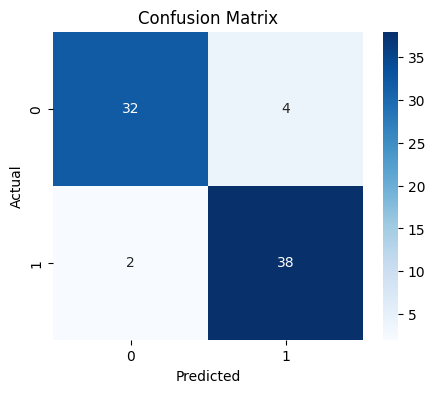

In [19]:
# Confusion matrix plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 7. Visualize Sentiment Results

We visualize sentiment distribution, model performance, and word clouds.

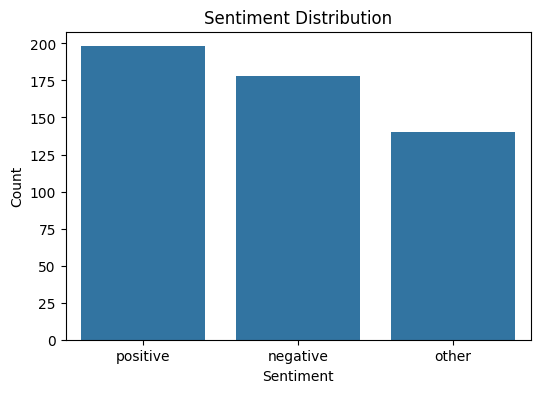

In [20]:
# Sentiment distribution
if "label" in sample_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=sample_df, x="label", order=sentiment_counts.index)
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

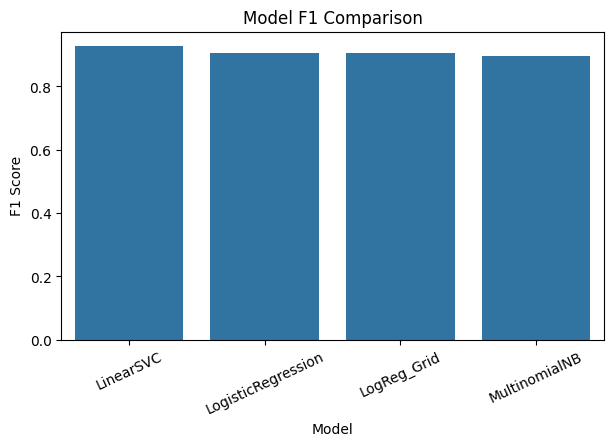

In [21]:
# Model performance chart
plt.figure(figsize=(7, 4))
sns.barplot(data=results_df, x="model", y="f1")
plt.title("Model F1 Comparison")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=25)
plt.show()

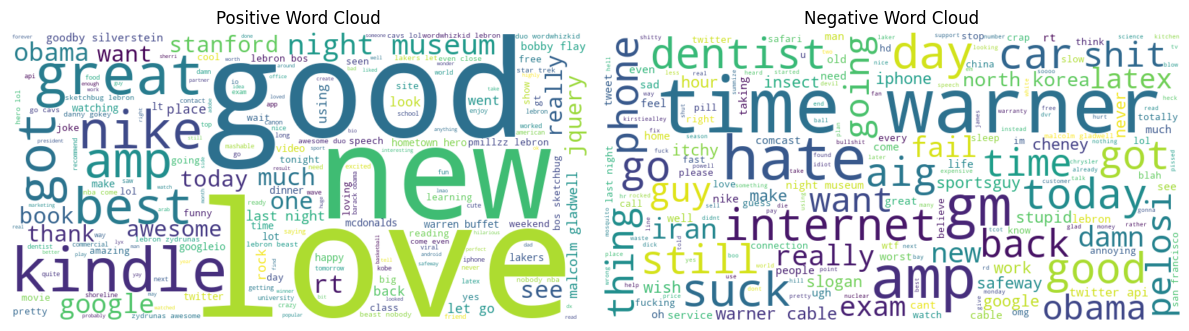

In [22]:
# Word clouds for positive and negative samples
positive_text = " ".join(train_df[train_df["y"] == 1]["clean_text"].head(10000))
negative_text = " ".join(train_df[train_df["y"] == 0]["clean_text"].head(10000))

wc_pos = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
wc_neg = WordCloud(width=800, height=400, background_color="white").generate(negative_text)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(wc_pos, interpolation="bilinear")
axes[0].set_title("Positive Word Cloud")
axes[0].axis("off")

axes[1].imshow(wc_neg, interpolation="bilinear")
axes[1].set_title("Negative Word Cloud")
axes[1].axis("off")

plt.tight_layout()
plt.show()